# 餐盘颜色识别

In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

from IPython.display import display, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 80))

def _IMPORT_(x):
    try:
        exec(x, globals())
    except:
        pass


CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed


In [2]:
###
### Common ###
###

import sys, os, io, time, random, math
import json, base64, requests
import os.path as osp

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')

def print_progress_bar(x):
    print('\r', end='')
    print('Progress: {}%:'.format(x), '%s%s' % ('▋'*(x//2), '.'*((100-x)//2)), end='')
    sys.stdout.flush()

###
### Display ###
###

_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('from torchvision.utils import make_grid')
_IMPORT_('import matplotlib.pyplot as plt')
_IMPORT_('import plotly')
_IMPORT_('import plotly.graph_objects as go')
_IMPORT_('import ipywidgets as widgets')
_IMPORT_('from ipywidgets import interact, interactive, fixed, interact_manual')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def show_video(vidsrc, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if vidsrc.startswith('http'):
        data_url = vidsrc
    else:
        mp4 = open(vidsrc, 'rb').read()
        data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(imgsrc, width=None, height=None):
    if isinstance(imgsrc, np.ndarray):
        img = imgsrc
        if width or height:
            if width and height:
                size = (width, height)
            else:
                rate = img.shape[1] / img.shape[0]
                if width:
                    size = (width, int(width/rate))
                else:
                    size = (int(height*rate), height)
            img = cv2.resize(img, size)
            plt.figure(figsize=(3*int(size[0]/80+1), 3*int(size[1]/80+1)), dpi=80)
        plt.axis('off')
        if len(img.shape) > 2:
            plt.imshow(img);
        else:
            plt.imshow(img, cmap='gray');
        return

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if imgsrc.startswith('http'):
        data_url = imgsrc
    else:
        if len(imgsrc) > 2048:
            data_url = 'data:image/jpg;base64,' + imgsrc
        else:
            img = open(imgsrc, 'rb').read()
            data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    if image_path.startswith('http'):
        data_url = image_path
    else:
        img = open(image_path, 'rb').read()
        data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

def im_read(url, rgb=True, size=None):
    response = requests.get(url)
    if response:
        imgmat = np.frombuffer(response.content, dtype=np.uint8)
        img = cv2.imdecode(imgmat, cv2.IMREAD_COLOR)
        if rgb:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if size:
           if isinstance(size, int):
               size = (size, size)
           img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        return img
    return None


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## HSV


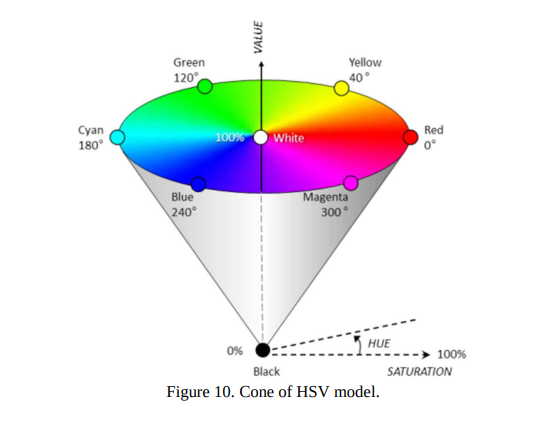

In [3]:
show_image('hsv.png')


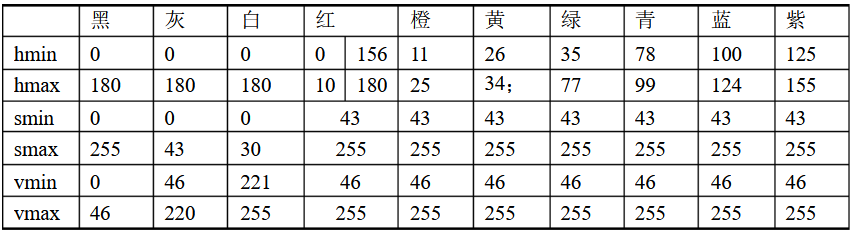

In [4]:
show_image('hsv_range.png')

In [5]:
def hsv_color(h, s, v):
    if s > 43 and v > 46:
        if (0 <= h and h <= 10) or (156 <= h and h <= 180):
            return 'red'
        if 11 <= h and h <= 25:
            return 'orange'
        if 26 <= h and h <= 34:
            return 'yellow'
        if 35 <= h and h <= 77:
            return 'green'
        if 78 <= h and h <= 99:
            return 'cyan'
        if 100 <= h and h <= 124:
            return 'blue'
        if 125 <= h and h <= 155:
            return 'purple'
    else:
        if s < 43 and v <= 220:
            return 'gray'
        if s < 30 and v >= 221:
            return 'white'
    return 'black'

In [6]:
COLORS_NAMES = ['black', 'gray', 'white', 'red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple']
NAME2INDEX = {name: x for x, name in enumerate(COLORS_NAMES)}
NAME2INDEX

{'black': 0,
 'gray': 1,
 'white': 2,
 'red': 3,
 'orange': 4,
 'yellow': 5,
 'green': 6,
 'cyan': 7,
 'blue': 8,
 'purple': 9}

## Sample Images

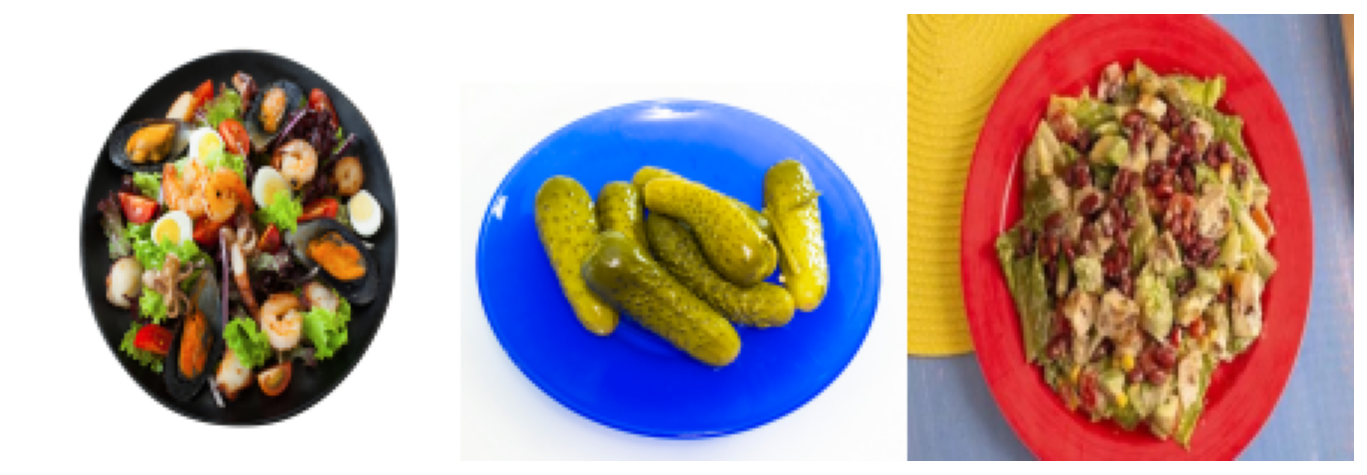

In [7]:
test_samples = [
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/black.png',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/blue.png',
    'https://raceai.s3.didiyunapi.com/data/datasets/cv/dining_plate/red_plate_1.jpg',
]

show_image(
    np.hstack([
        im_read(test_samples[0], size=150),
        im_read(test_samples[1], size=150),
        im_read(test_samples[2], size=150)])
)

## Color Spaces

In [8]:
img_rgb = im_read(test_samples[1], size=200)

w, h, c = img_rgb.shape
pixel_colors = img_rgb.reshape(-1, c)
norm = colors.Normalize(vmin=0., vmax=1.)
norm.autoscale(pixel_colors) # set: vmin = np.min(pixel_colors), vmax = np.max(pixel_colors)
pixel_colors_list = norm(pixel_colors).tolist()
pixel_colors_list[int(w*h*0.5)]

[0.9607843160629272, 0.9725490212440491, 0.9686274528503418]

### RGB Color Space

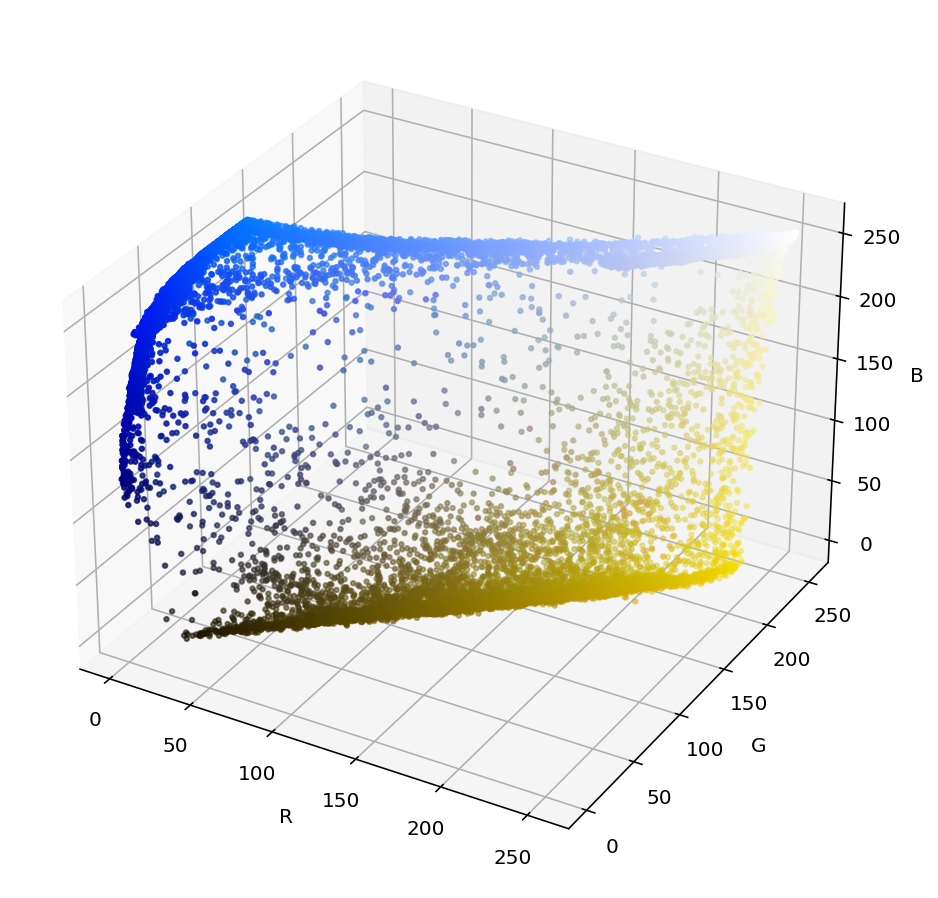

In [9]:
r, g, b = cv2.split(img_rgb) 

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors_list, marker=".")
axis.set_xlabel("R")
axis.set_ylabel("G")
axis.set_zlabel("B");

### HSV Color Space

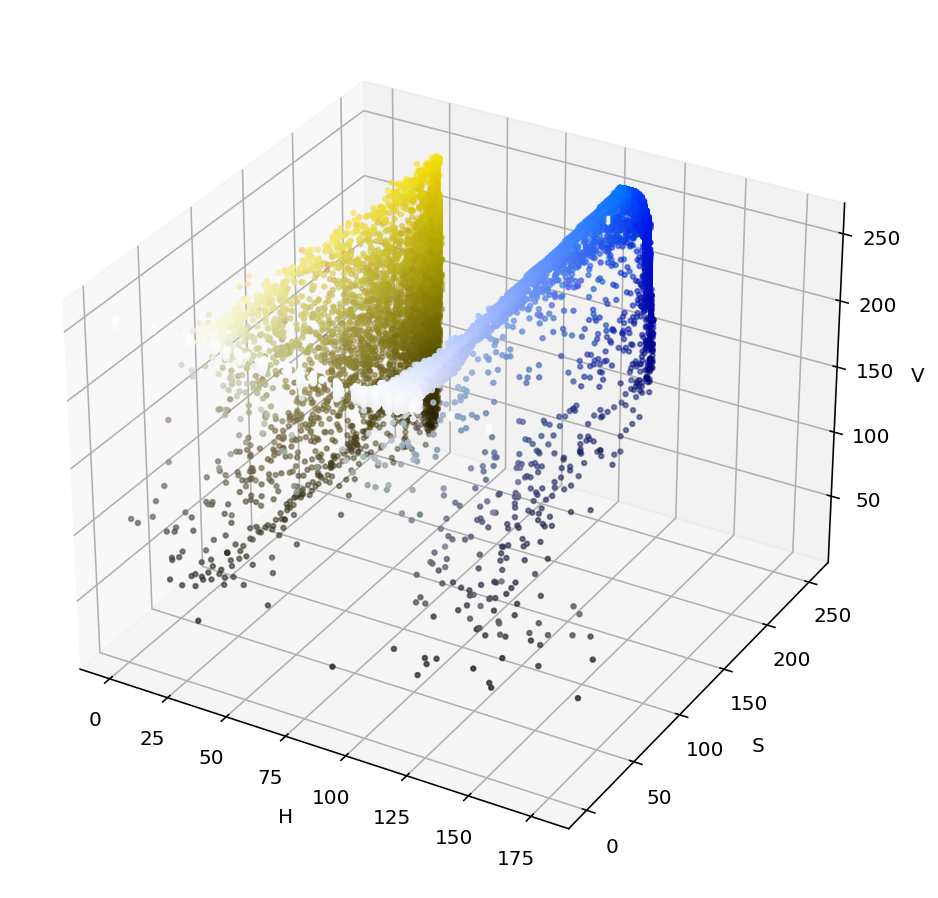

In [10]:
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(img_hsv)

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors_list, marker=".")
axis.set_xlabel("H")
axis.set_ylabel("S")
axis.set_zlabel("V");

## Recognize Dining Plate Color

In [11]:
def extract_color_features(imgpath, ellsize, iterations, thickness):
    img_rgb = im_read(imgpath)
    # add white borader for canny
    img_rgb = cv2.copyMakeBorder(
        img_rgb,
        top=2,
        bottom=2,
        left=2,
        right=2,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )
    
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) 
    img_blur = cv2.GaussianBlur(img_gray, (15, 15), 0)
    img_blur = cv2.GaussianBlur(img_blur, (3, 3), 0)

    img_canny = cv2.Canny(img_blur, 30, 150)

    ellipses = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (ellsize, ellsize))

    mask_close = cv2.morphologyEx(img_canny, cv2.MORPH_CLOSE, ellipses, iterations=iterations)

    contours = cv2.findContours(
        mask_close,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[0]

    contours_sorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

    plate_mask = np.zeros(img_gray.shape, np.uint8)

    cv2.drawContours(plate_mask, [contours_sorted[0]], 0, (255, 255, 255), thickness)

    inner_contours = cv2.findContours(
        plate_mask,
        cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[0]

    inner_contours_sorted = sorted(inner_contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
    edge_mask = np.zeros(img_gray.shape, np.uint8)
    cv2.drawContours(edge_mask, [inner_contours_sorted[1]], 0, (255, 255, 255), -1) # thickness: -1 for display
    rgb_masked = cv2.bitwise_and(img_rgb, img_rgb, mask=edge_mask)
    img_hsv = cv2.cvtColor(rgb_masked, cv2.COLOR_RGB2HSV)
    
    colors_count = { x:0 for x in COLORS_NAMES}
    for item in inner_contours_sorted[1]:
        x, y = item[0]
        h, s, v = img_hsv[y, x, :]
        colors_count[hsv_color(h, s, v)] += 1
        
    print(colors_count)
    
    # debug
    rgb_canny = cv2.cvtColor(img_canny, cv2.COLOR_GRAY2RGB)
    rgb_close = cv2.cvtColor(mask_close, cv2.COLOR_GRAY2RGB)
    rgb_plate_mask = cv2.cvtColor(plate_mask, cv2.COLOR_GRAY2RGB)
    rgb_edge_mask = cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB)
    show_image(
        np.vstack([
            np.hstack([img_rgb, rgb_canny, rgb_close]),
            np.hstack([rgb_plate_mask, rgb_edge_mask, rgb_masked])
        ])
    )
# extract_color_features(test_samples[1], 15, 2, 25)

In [12]:
widgets.interact_manual(
    extract_color_features,
    imgpath=widgets.Dropdown(options=[(p.split('/')[-1][:-4], p) for p in test_samples]),
    ellsize=widgets.IntSlider(min=1, max=32, value=8),
    iterations=widgets.IntSlider(min=1, max=10, value=2),
    thickness=widgets.IntSlider(min=1, max=60, value=2),
);

interactive(children=(Dropdown(description='imgpath', options=(('black', 'https://raceai.s3.didiyunapi.com/dat…

## References

1. http://oa.upm.es/40591/3/TFG_JULIAN_CALDERON_GONZALEZ.pdf

2. https://realpython.com/python-opencv-color-spaces/

3. https://blog.csdn.net/eternity1118_/article/details/51492105

4. https://medium.com/analytics-vidhya/morphological-transformations-of-images-using-opencv-image-processing-part-2-f64b14af2a38

5. https://python.plainenglish.io/complete-understanding-of-morphological-transformations-in-image-processing-eadb337e9d5c

6. cv2.copyMakeBorder() https://my.oschina.net/u/4870686/blog/4956432

7. Canny原理:https://www.pyimagesearch.com/2021/05/12/opencv-edge-detection-cv2-canny/

8. 边缘类型 https://blog.csdn.net/wsp_1138886114/article/details/82935839

9. https://medium.com/smileinnovation/capturing-your-dinner-a-deep-learning-story-bf8f8b65f26f

10. https://coderzcolumn.com/tutorials/python/interactive-widgets-in-jupyter-notebook-using-ipywidgets